# Drosophila Three Epoch Parameter Comparison

This notebook compares estimated parameters from moments optimization with ground truth values across all simulations in the drosophila_three_epoch experiment.

## Overview
- **Ground Truth**: Parameters from `sampled_params.pkl` files in simulation directories
- **Estimates**: First element of `best_params` from `fit_params.pkl` files in inference directories
- **Analysis**: Scatter plots, correlations, and error distributions for each parameter

In [6]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("Libraries imported successfully!")

Libraries imported successfully!


In [7]:
# Configure Paths and Settings
EXPERIMENT_NAME = 'drosophila_three_epoch'
BASE_PATH = Path(f'/home/akapoor/kernlab/Infer_Demography/neutral_experiments/{EXPERIMENT_NAME}')
SIMULATIONS_PATH = BASE_PATH / 'simulations'
INFERENCES_PATH = BASE_PATH / 'unconstrained_analysis' / 'inferences'

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Base path: {BASE_PATH}")
print(f"Simulations path: {SIMULATIONS_PATH}")
print(f"Inferences path: {INFERENCES_PATH}")
print(f"Paths exist: simulations={SIMULATIONS_PATH.exists()}, inferences={INFERENCES_PATH.exists()}")

# Check directory contents
if SIMULATIONS_PATH.exists():
    sim_dirs = [d for d in SIMULATIONS_PATH.iterdir() if d.is_dir()]
    print(f"Found {len(sim_dirs)} simulation directories")
    
if INFERENCES_PATH.exists():
    inf_dirs = [d for d in INFERENCES_PATH.iterdir() if d.is_dir()]
    print(f"Found {len(inf_dirs)} inference directories")

Experiment: drosophila_three_epoch
Base path: /home/akapoor/kernlab/Infer_Demography/neutral_experiments/drosophila_three_epoch
Simulations path: /home/akapoor/kernlab/Infer_Demography/neutral_experiments/drosophila_three_epoch/simulations
Inferences path: /home/akapoor/kernlab/Infer_Demography/neutral_experiments/drosophila_three_epoch/unconstrained_analysis/inferences
Paths exist: simulations=True, inferences=True
Found 20000 simulation directories
Found 20000 inference directories


In [8]:
# Define Data Loading Functions

def load_ground_truth_parameters(simulations_path):
    """Load ground truth parameters from all simulation directories."""
    ground_truth = {}
    
    for sim_dir in sorted(simulations_path.glob('*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                ground_truth[sim_id] = params
                print(f"Loaded ground truth for sim {sim_id}: {list(params.keys())}")
            except Exception as e:
                print(f"Error loading {param_file}: {e}")
    
    print(f"\nTotal ground truth loaded: {len(ground_truth)} simulations")
    return ground_truth

def load_estimated_parameters(inferences_path):
    """Load estimated parameters (first element of best_params) from fit_params.pkl files."""
    estimates = {}
    
    for sim_dir in sorted(inferences_path.glob('sim_*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name.replace('sim_', '')  # Remove 'sim_' prefix
        moments_dir = sim_dir / 'moments'
        param_file = moments_dir / 'fit_params.pkl'
        
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    data = pickle.load(f)
                
                # Extract first element of best_params
                if isinstance(data, dict) and 'best_params' in data:
                    best_params = data['best_params']
                    if isinstance(best_params, (list, tuple)) and len(best_params) > 0:
                        # Get the first optimization result
                        first_result = best_params[0]
                        if isinstance(first_result, dict):
                            estimates[sim_id] = first_result
                            print(f"Loaded estimates for sim {sim_id}: {list(first_result.keys())}")
                        else:
                            print(f"Unexpected format for sim {sim_id}: first result is not dict")
                    else:
                        print(f"No best_params found or empty for sim {sim_id}")
                else:
                    print(f"Unexpected data format for sim {sim_id}: {type(data)}")
                    
            except Exception as e:
                print(f"Error loading {param_file}: {e}")
        else:
            print(f"fit_params.pkl not found for sim {sim_id}")
    
    print(f"\nTotal estimates loaded: {len(estimates)} simulations")
    return estimates

def extract_common_parameters(ground_truth, estimates):
    """Find parameters that exist in both ground truth and estimates."""
    if not ground_truth or not estimates:
        return set()
    
    # Get parameter names from first simulation that has both GT and estimates
    common_sims = set(ground_truth.keys()) & set(estimates.keys())
    if not common_sims:
        return set()
    
    first_sim = list(common_sims)[0]
    gt_params = set(ground_truth[first_sim].keys())
    est_params = set(estimates[first_sim].keys())
    
    common_params = gt_params & est_params
    print(f"Common parameters: {sorted(common_params)}")
    return common_params

print("Data loading functions defined!")

Data loading functions defined!


In [9]:
# Load and Process All Simulation Data

print("Loading ground truth parameters...")
ground_truth = load_ground_truth_parameters(SIMULATIONS_PATH)

print("\nLoading estimated parameters...")
estimates = load_estimated_parameters(INFERENCES_PATH)

print("\nFinding common parameters...")
common_params = extract_common_parameters(ground_truth, estimates)

# Create comparison dataset
comparison_data = []
common_sims = set(ground_truth.keys()) & set(estimates.keys())

print(f"\nProcessing {len(common_sims)} simulations with both GT and estimates...")

for sim_id in sorted(common_sims):
    gt_params = ground_truth[sim_id]
    est_params = estimates[sim_id]
    
    for param in common_params:
        if param in gt_params and param in est_params:
            gt_val = gt_params[param]
            est_val = est_params[param]
            
            comparison_data.append({
                'simulation': sim_id,
                'parameter': param,
                'ground_truth': gt_val,
                'estimated': est_val,
                'absolute_error': est_val - gt_val,
                'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan
            })

# Create DataFrame
df = pd.DataFrame(comparison_data)

print(f"\nComparison dataset created:")
print(f"- Total data points: {len(df)}")
print(f"- Parameters: {sorted(df['parameter'].unique())}")
print(f"- Simulations: {len(df['simulation'].unique())}")

# Show sample data
print(f"\nSample data:")
display(df.head(10))

Loading ground truth parameters...
Loaded ground truth for sim 0: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansion']
Loaded ground truth for sim 1: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansion']
Loaded ground truth for sim 10: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansion']
Loaded ground truth for sim 100: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansion']
Loaded ground truth for sim 1000: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansion']
Loaded ground truth for sim 10000: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansion']
Loaded ground truth for sim 10001: ['N0', 'AFR', 'EUR_bottleneck', 'EUR_recover', 'T_AFR_expansion', 'T_AFR_EUR_split', 'T_EUR_expansion']
Loaded

simulation        parameter   ground_truth      estimated  absolute_error  \
0          1   EUR_bottleneck    3537.357324    3619.148083       81.790758   
1          1  T_EUR_expansion    6747.978842    6618.437597     -129.541245   
2          1  T_AFR_expansion  195265.443089   97608.619762   -97656.823327   
3          1               N0    7914.261306   10263.332525     2349.071219   
4          1  T_AFR_EUR_split   20855.855872   21001.502556      145.646684   
5          1              AFR   10595.855408   10848.998158      253.142750   
6          1      EUR_recover   10885.867203   10863.104273      -22.762930   
7         10   EUR_bottleneck    3959.993275    4354.473794      394.480519   
8         10  T_EUR_expansion    1803.091669    1756.039245      -47.052424   
9         10  T_AFR_expansion  134509.433262  104983.456960   -29525.976303   

   relative_error  
0        0.023122  
1       -0.019197  
2       -0.500123  
3        0.296815  
4        0.006983  
5        0.023891  
6       -0.002091  
7        0.099616  
8       -0.026095  
9       -0.219509

Creating comparison plots for 7 parameters...

Plotting AFR...


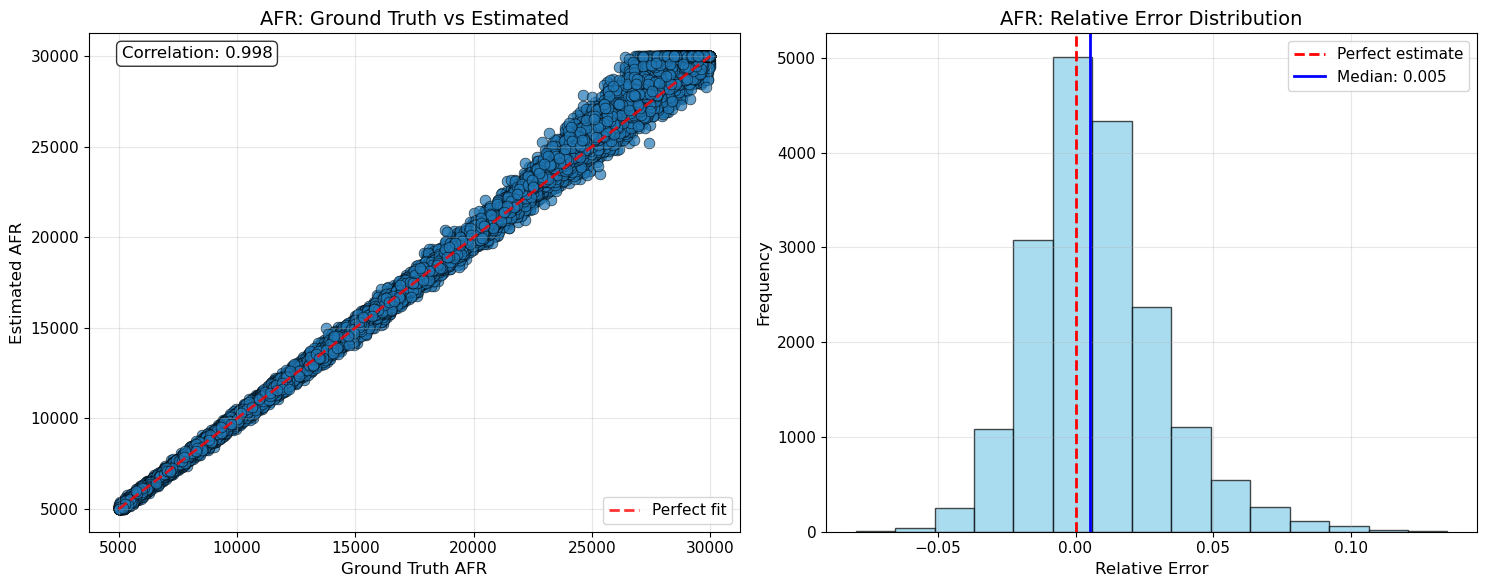

Correlation coefficient: 0.9979
----------------------------------------

Plotting EUR_bottleneck...


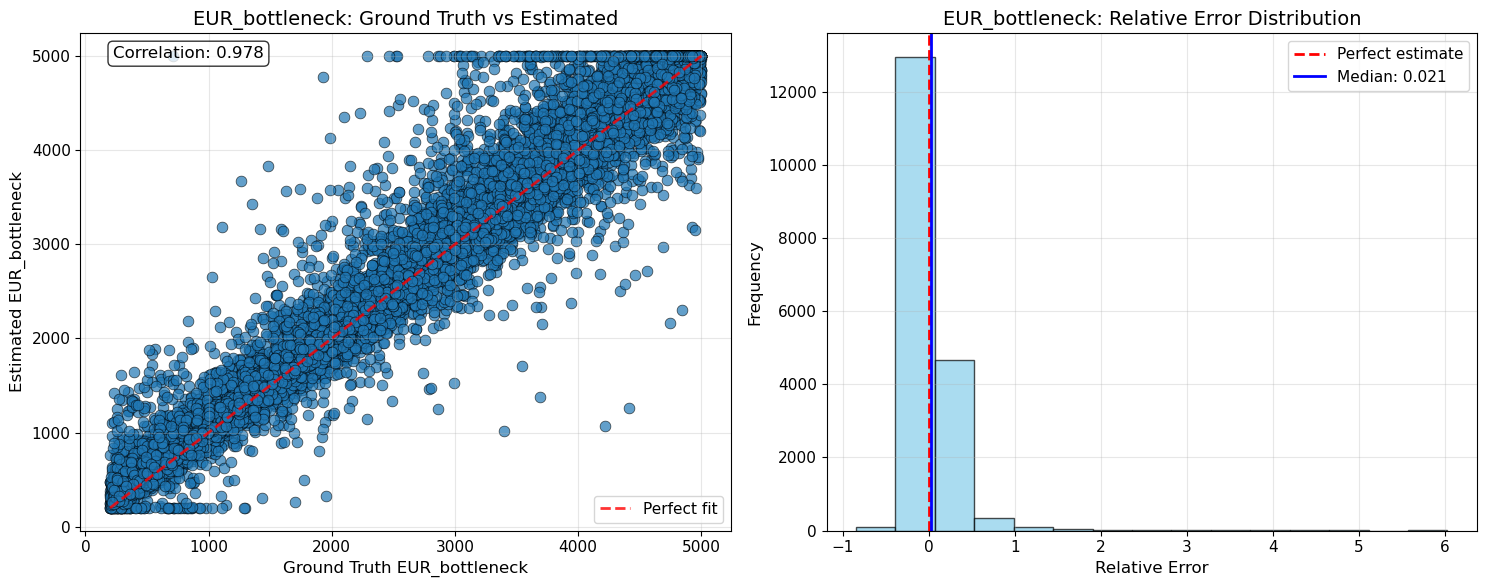

Correlation coefficient: 0.9779
----------------------------------------

Plotting EUR_recover...


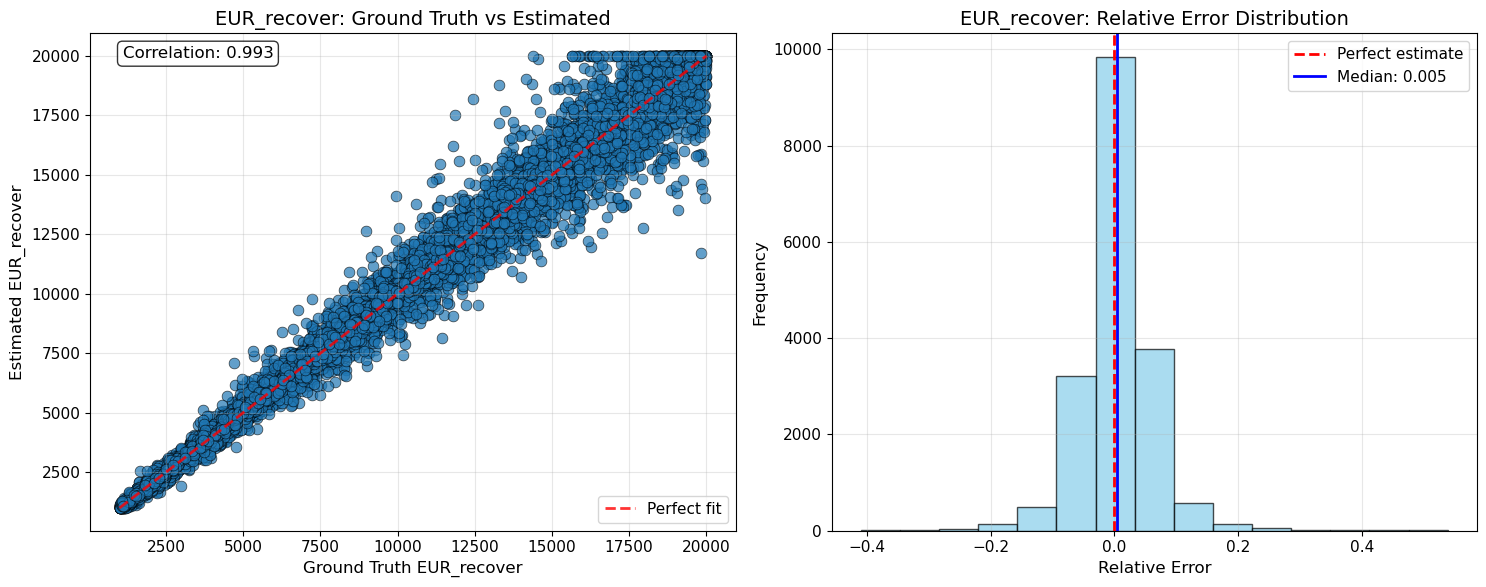

Correlation coefficient: 0.9934
----------------------------------------

Plotting N0...


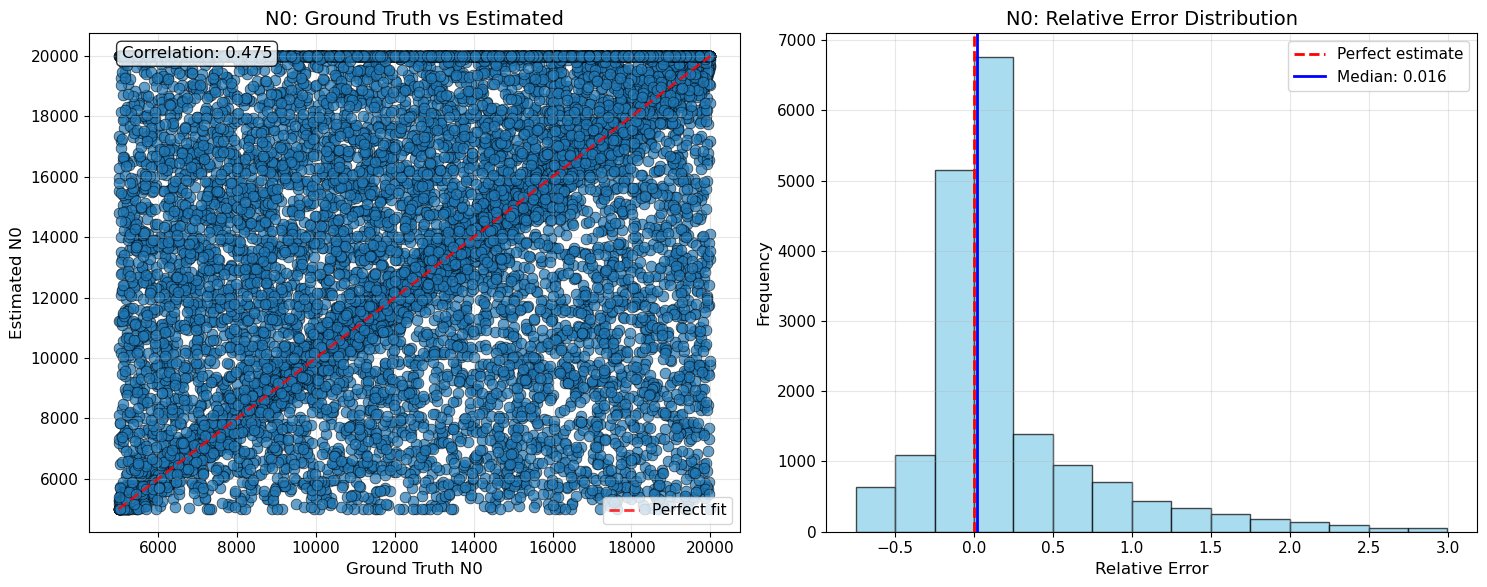

Correlation coefficient: 0.4752
----------------------------------------

Plotting T_AFR_EUR_split...


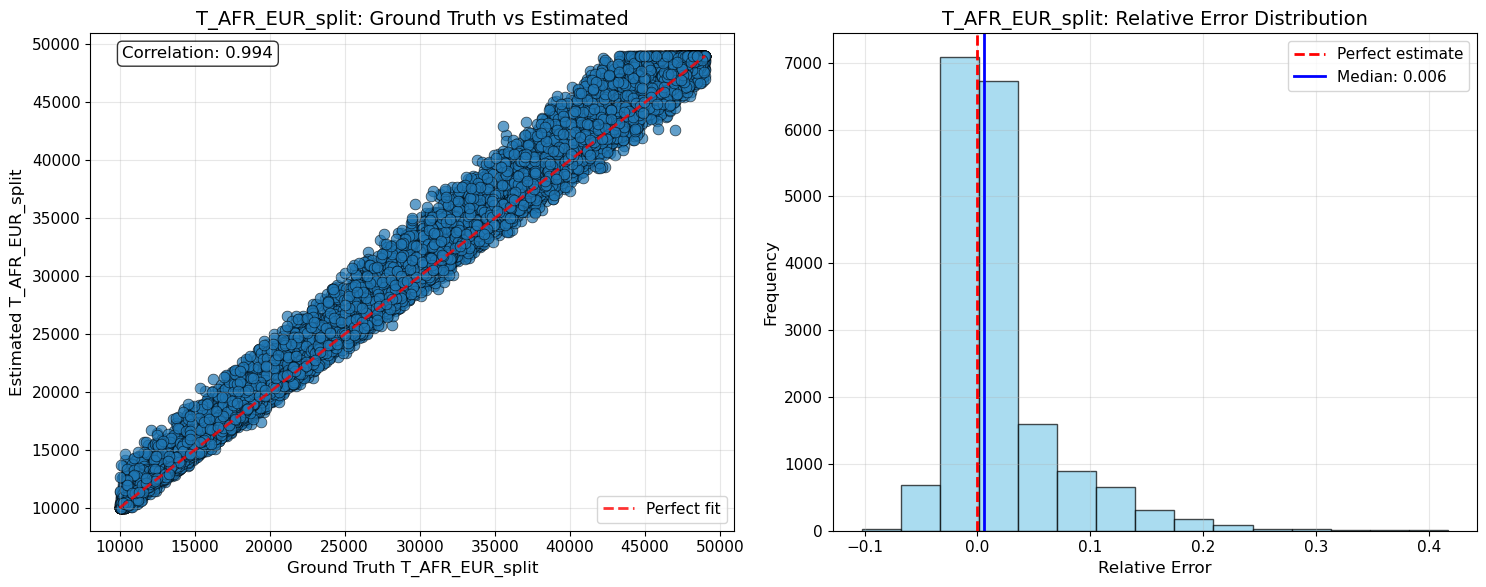

Correlation coefficient: 0.9939
----------------------------------------

Plotting T_AFR_expansion...


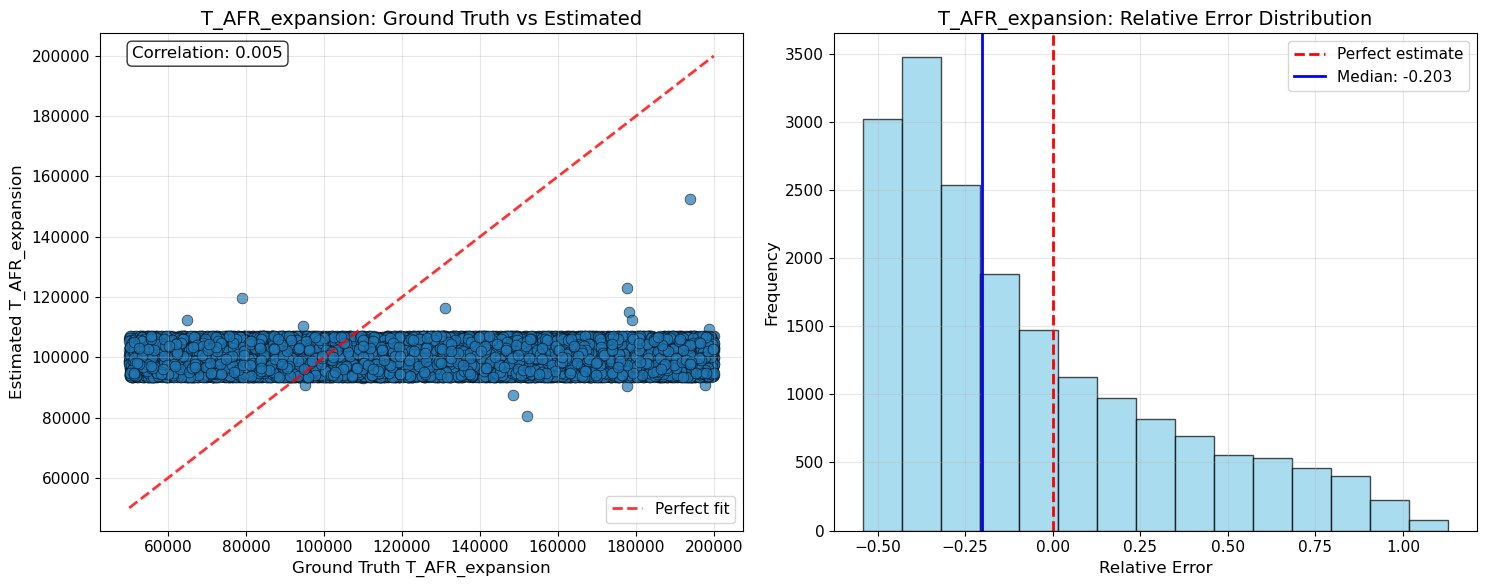

Correlation coefficient: 0.0052
----------------------------------------

Plotting T_EUR_expansion...


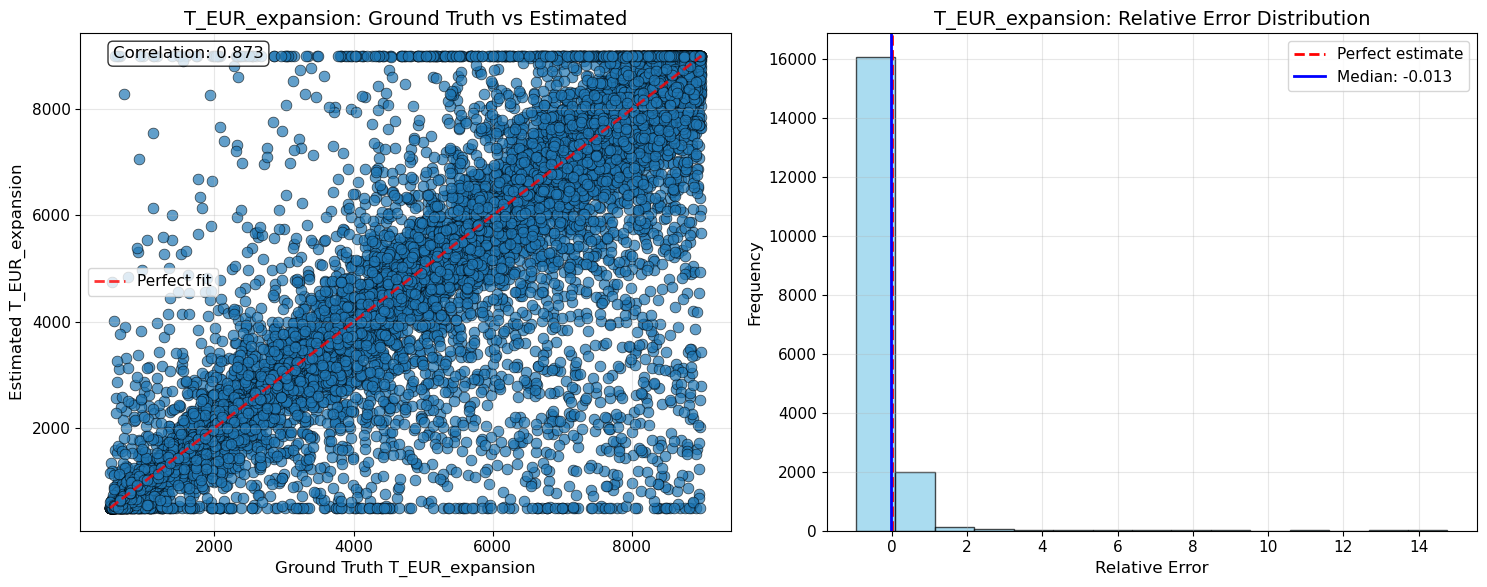

Correlation coefficient: 0.8725
----------------------------------------


In [10]:
# Create Parameter Comparison Plots

def plot_parameter_comparison(df, param_name):
    """Create a scatter plot comparing ground truth vs estimated values for a parameter."""
    param_data = df[df['parameter'] == param_name]
    
    if len(param_data) == 0:
        print(f"No data for parameter {param_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot with identity line
    ax1.scatter(param_data['ground_truth'], param_data['estimated'], 
                alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
    
    # Identity line (perfect prediction)
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect fit')
    
    # Calculate and display correlation
    correlation = param_data['ground_truth'].corr(param_data['estimated'])
    ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=ax1.transAxes, fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    ax1.set_xlabel(f'Ground Truth {param_name}', fontsize=12)
    ax1.set_ylabel(f'Estimated {param_name}', fontsize=12)
    ax1.set_title(f'{param_name}: Ground Truth vs Estimated', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Error distribution
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=15, alpha=0.7, edgecolor='black', color='skyblue')
        ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', linewidth=2,
                   label=f'Median: {valid_errors.median():.3f}')
        
        ax2.set_xlabel('Relative Error', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.set_title(f'{param_name}: Relative Error Distribution', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return correlation

# Plot comparison for each parameter
parameters = sorted(df['parameter'].unique())
correlations = {}

print(f"Creating comparison plots for {len(parameters)} parameters...")
print("="*60)

for param in parameters:
    print(f"\nPlotting {param}...")
    corr = plot_parameter_comparison(df, param)
    correlations[param] = corr
    print(f"Correlation coefficient: {corr:.4f}")
    print("-"*40)

In [ ]:
# Generate Summary Statistics

print("PARAMETER ESTIMATION SUMMARY")
print("="*60)

summary_stats = []

for param in parameters:
    param_data = df[df['parameter'] == param]
    
    # Calculate statistics
    n_points = len(param_data)
    correlation = param_data['ground_truth'].corr(param_data['estimated'])
    
    # Error metrics
    abs_errors = np.abs(param_data['absolute_error'])
    rel_errors = np.abs(param_data['relative_error'].dropna())
    
    mae = abs_errors.mean()  # Mean Absolute Error
    rmse = np.sqrt((param_data['absolute_error']**2).mean())  # Root Mean Square Error
    
    mean_rel_error = rel_errors.mean() if len(rel_errors) > 0 else np.nan
    median_rel_error = rel_errors.median() if len(rel_errors) > 0 else np.nan
    
    # Accuracy within thresholds
    within_5pct = (rel_errors <= 0.05).sum() if len(rel_errors) > 0 else 0
    within_10pct = (rel_errors <= 0.10).sum() if len(rel_errors) > 0 else 0
    within_20pct = (rel_errors <= 0.20).sum() if len(rel_errors) > 0 else 0
    
    print(f"\n{param}:")
    print(f"  Data points: {n_points}")
    print(f"  Correlation: {correlation:.4f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  Mean |rel error|: {mean_rel_error:.4f}")
    print(f"  Median |rel error|: {median_rel_error:.4f}")
    print(f"  Within 5%: {within_5pct}/{len(rel_errors)} ({100*within_5pct/len(rel_errors) if len(rel_errors) > 0 else 0:.1f}%)")
    print(f"  Within 10%: {within_10pct}/{len(rel_errors)} ({100*within_10pct/len(rel_errors) if len(rel_errors) > 0 else 0:.1f}%)")
    print(f"  Within 20%: {within_20pct}/{len(rel_errors)} ({100*within_20pct/len(rel_errors) if len(rel_errors) > 0 else 0:.1f}%)")
    
    # Store for summary table
    summary_stats.append({
        'Parameter': param,
        'N_Points': n_points,
        'Correlation': correlation,
        'MAE': mae,
        'RMSE': rmse,
        'Mean_Rel_Error': mean_rel_error,
        'Within_5pct': 100*within_5pct/len(rel_errors) if len(rel_errors) > 0 else 0,
        'Within_10pct': 100*within_10pct/len(rel_errors) if len(rel_errors) > 0 else 0
    })

# Create summary table
summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.round(4)

print(f"\n\nSUMMARY TABLE:")
print("="*60)
display(summary_df)

In [ ]:
# Plot Parameter Error Distributions

def plot_error_distributions():
    """Create comprehensive error distribution plots."""
    n_params = len(parameters)
    cols = min(3, n_params)
    rows = (n_params + cols - 1) // cols
    
    # Absolute errors
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_params == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if cols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('Absolute Error Distributions by Parameter', fontsize=16, y=1.02)
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        param_data = df[df['parameter'] == param]
        abs_errors = np.abs(param_data['absolute_error'])
        
        ax.hist(abs_errors, bins=15, alpha=0.7, edgecolor='black', color='lightcoral')
        ax.set_title(f'{param}', fontsize=12)
        ax.set_xlabel('Absolute Error', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        mean_error = abs_errors.mean()
        ax.axvline(mean_error, color='red', linestyle='--', 
                  label=f'Mean: {mean_error:.4f}')
        ax.legend(fontsize=9)
    
    # Hide unused subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Relative errors
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_params == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if cols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('Relative Error Distributions by Parameter', fontsize=16, y=1.02)
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        param_data = df[df['parameter'] == param]
        rel_errors = param_data['relative_error'].dropna()
        
        if len(rel_errors) > 0:
            ax.hist(rel_errors, bins=15, alpha=0.7, edgecolor='black', color='lightblue')
            ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect estimate')
            
            mean_error = rel_errors.mean()
            ax.axvline(mean_error, color='blue', linestyle='-', 
                      label=f'Mean: {mean_error:.3f}')
            
            ax.set_title(f'{param}', fontsize=12)
            ax.set_xlabel('Relative Error', fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
    
    # Hide unused subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Overall correlation summary
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
param_names = list(correlations.keys())
corr_values = list(correlations.values())

bars = ax.bar(param_names, corr_values, alpha=0.7, edgecolor='black')
ax.set_ylabel('Correlation Coefficient', fontsize=12)
ax.set_title('Parameter Estimation Correlations (Ground Truth vs Estimated)', fontsize=14)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

# Color bars based on correlation strength
for bar, corr in zip(bars, corr_values):
    if corr >= 0.9:
        bar.set_color('green')
    elif corr >= 0.7:
        bar.set_color('orange')
    else:
        bar.set_color('red')

# Add value labels on bars
for bar, corr in zip(bars, corr_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{corr:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Generate error distribution plots
plot_error_distributions()

print("\nAnalysis complete!")
print("="*60)
print("Key insights:")
print(f"- Total simulations analyzed: {len(df['simulation'].unique())}")
print(f"- Parameters compared: {len(parameters)}")
print(f"- Best correlation: {max(correlations.values()):.3f} ({max(correlations, key=correlations.get)})")
print(f"- Worst correlation: {min(correlations.values()):.3f} ({min(correlations, key=correlations.get)})")
print(f"- Average correlation: {np.mean(list(correlations.values())):.3f}")